In [103]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42

In [104]:
# dataset = Path('gestures_dataset_new.csv')
DATASET_CSV = Path('../gestures_dataset.csv')
DATASET_ROOT = Path('../ai_data/vgt-all')

UPLOADED_DATASET_CSV = Path('../uploaded_gestures_dataset.csv')
UPLOADED_DATASET_ROOT = Path('../ai_data/vgt-uploaded')

In [105]:
%load_ext autoreload
%autoreload 2
from sl_ai.gesture_classifier import GestureClassifier
from sl_ai.dataset import GestureDataset

gesture_dataset: GestureDataset = GestureDataset()
gesture_dataset.load_from_csv(DATASET_CSV)

uploaded_dataset: GestureDataset = GestureDataset()
uploaded_dataset.load_from_csv(UPLOADED_DATASET_CSV)

gesture_dataset.append_dataset(uploaded_dataset)

gesture_dataset.summary()

classifier: GestureClassifier = GestureClassifier(gesture_dataset=gesture_dataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2

In [106]:
classifier.train(save=False, train_size=.5)
classifier.summary()

Training model:
Dataset contain 4 gestures.
Epoch 1/1000
16/16 [==============================] - 0s 8ms/step - loss: 1.4185 - accuracy: 0.3125 - val_loss: 1.4014 - val_accuracy: 0.5000
Epoch 2/1000
16/16 [==============================] - 0s 2ms/step - loss: 1.5816 - accuracy: 0.2500 - val_loss: 1.0615 - val_accuracy: 0.6250
Epoch 3/1000
16/16 [==============================] - 0s 2ms/step - loss: 1.3343 - accuracy: 0.5000 - val_loss: 0.9552 - val_accuracy: 0.6250
Epoch 4/1000
16/16 [==============================] - 0s 3ms/step - loss: 1.1612 - accuracy: 0.4375 - val_loss: 0.8932 - val_accuracy: 0.6250
Epoch 5/1000
16/16 [==============================] - 0s 3ms/step - loss: 1.3856 - accuracy: 0.3750 - val_loss: 0.7971 - val_accuracy: 0.6250
Epoch 6/1000
16/16 [==============================] - 0s 3ms/step - loss: 1.2239 - accuracy: 0.5000 - val_loss: 0.8082 - val_accuracy: 0.6250
Epoch 7/1000
16/16 [==============================] - 0s 2ms/step - loss: 1.1680 - accuracy: 0.3750 - va

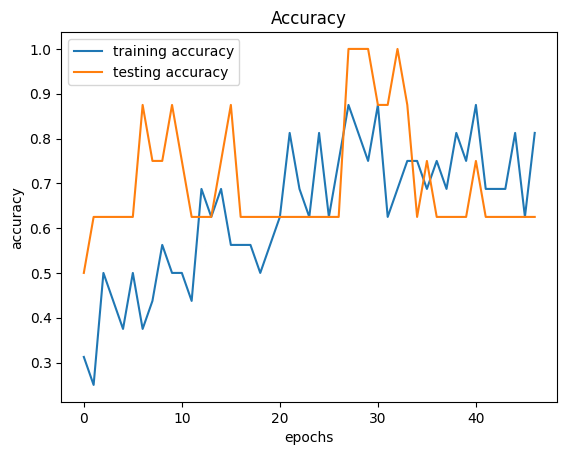

In [107]:
classifier.visualize_accuracy()

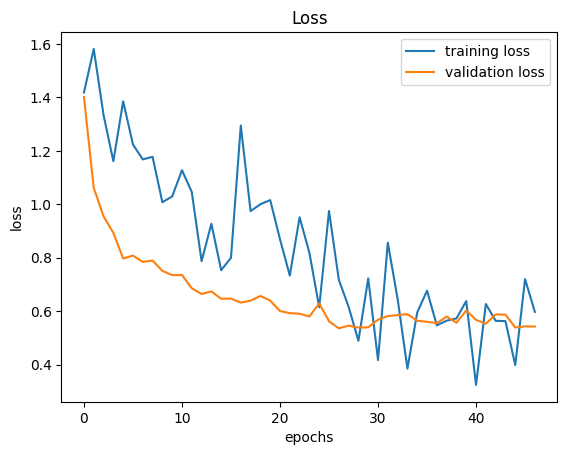

In [108]:
classifier.visualize_loss()

1/1 [==============================] - 0s 40ms/step


C:\Users\Arthur\Desktop\EhB\22-23\Final Work\Sign-Language-Learning-Tool\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Arthur\Desktop\EhB\22-23\Final Work\Sign-Language-Learning-Tool\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Arthur\Desktop\EhB\22-23\Final Work\Sign-Language-Learning-Tool\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         6
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1

    accuracy                           0.33         9
   macro avg       0.50      0.50      0.50         9
weighted avg       0.33      0.33      0.33         9



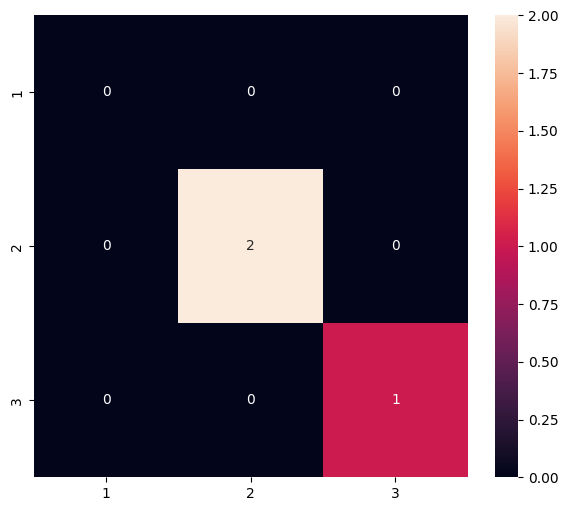

In [109]:
classifier.confusion_matrix()